## Direct features:
Features which are a directly due to words/content. We would be exploring the following techniques:

- Word frequency features
- Count features
- Bigrams
- Trigrams
- Vector distance mapping of words (Eg: Word2Vec)
- Sentiment scores

## Indirect features:
Some more experimental features:

- count of sentences
- count of words
- count of unique words
- count of letters
- count of punctuations
- count of uppercase words/letters
- count of stop words
- Avg length of each word

# Libraries

In [2]:
# misc
import gc
import pickle

# dataframes and arrays
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# nlp
import string
import re  
import nltk
import spacy
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer # Tweet tokenizer does not split at apostophes which is what we want

# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#utilities
from utilities.constants import *
from utilities.functions import *

# notebook configurations
sns.set_style("whitegrid")
my_pal = sns.color_palette(n_colors=10)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# directories
DATA_DIR = './data/'

# word parsers/lemmatizers
lemmatizer = WordNetLemmatizer()
tokenizer = TweetTokenizer()
spacy_parser = spacy.load("en_core_web_sm")

In [2]:
df_train = pd.read_csv(DATA_DIR + 'train.csv', usecols= CLASSES + ['comment_text'])\
             .rename(columns = {'comment_text': 'comment'})

In [3]:
df_train.head()

,comment,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
df_test = pd.read_csv(DATA_DIR + 'test.csv', usecols= ['comment_text'])\
             .rename(columns = {'comment_text': 'comment'})

In [5]:
df_all = pd.concat([df_train[['comment']], df_test])\
           .reset_index(drop=True)

In [6]:
df_all

,comment
0,Explanation\nWhy the edits made under my usern...
1,D'aww! He matches this background colour I'm s...
2,"Hey man, I'm really not trying to edit war. It..."
3,"""\nMore\nI can't make any real suggestions on ..."
4,"You, sir, are my hero. Any chance you remember..."
...,...
312730,". \n i totally agree, this stuff is nothing bu..."
312731,== Throw from out field to home plate. == \n\n...
312732,""" \n\n == Okinotorishima categories == \n\n I ..."
312733,""" \n\n == """"One of the founding nations of the..."


# I. Indirect Features 

In [7]:

# #Sentense count in each comment:
#     #  '\n' can be used to count the number of sentences in each comment
# df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
# #Word count in each comment:
# df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
# #Unique word count
# df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))
# #Letter count
# df['count_letters']=df["comment_text"].apply(lambda x: len(str(x)))
# #punctuation count
# df["count_punctuations"] =df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
# #upper case words count
# df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
# #title case words count
# df["count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
# #Number of stopwords
# df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
# #Average length of the words
# df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [8]:
# #derived features
# #Word count percent in each comment:
# df['word_unique_percent']=df['count_unique_word']*100/df['count_word']
# #derived features
# #Punct percent in each comment:
# df['punct_percent']=df['count_punctuations']*100/df['count_word']

# II. Direct Features 

In [9]:
def clean_text(comment, spacy=False):
    
    # Step 1: Clean text
    ## 1.a Convert to lower case, so that Hi and hi are the same
    comment = comment.lower()
    ## 1.b Remove urls
    comment = re.sub("http\S+", "", comment)
    ## 1.c Remove leaky elements like ip,user
    comment = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}", "", comment)
    ## 1.d Removing usernames
    comment = re.sub("\[\[.*\]", "",  comment)
    
    
    
    
    # TODO: remove non-alphabetic characters
    
    
    # Step 2: Tokenization (Split sentences into words)
    if spacy:
        tokens = spacy_parser(comment)
    else:
        tokens = tokenizer.tokenize(comment)
                                  
    
    # Step 3: Normalization/Lemmatization
    norm_tokens = []
    for token in tokens:
        #3.a (')aphostophe  replacement (ie)   you're --> you are  
        if token in APPOSTROPHES:
            token = APPOSTROPHES[token]
        #3.b lemmatization 
        if spacy:
            if token.lemma_ != "-PRON-":
                token = token.lemma_.strip()
        else:
            token = lemmatizer.lemmatize(token, "v")
        
        #3.c remove stopwords and punctation
        if (token in STOPWORDS) or (token in PUNCTUATION) or (str(token) in WHITESPACE):
            continue
    
        norm_tokens.append(str(token))  
   
    return " ".join(norm_tokens).strip()

## Comment:
```spacy``` parser is $\sim\times 20$ slower than the ```nltk``` parser

In [10]:
# %timeit df_all[['comment']].iloc[:100].applymap(lambda x: clean_text(x, spacy=False))

In [11]:
# %timeit df_all[['comment']].iloc[:100].applymap(lambda x: clean_text(x, spacy=True))

In [12]:
df_all['comment'] = df_all['comment'].apply(lambda x: clean_text(x, spacy=False))

In [ ]:
#TF-IDF is easy to compute but its disadvantage is that
#it does not capture position in text, semantics, 
#co-occurrences in different documents, etc.

In [13]:
top_tfidf_ngrams = {}
ngram_types = ['unigrams', 'bigrams', 'trigrams']
for i, ngram_type in enumerate(ngram_types):
    tfv = TfidfVectorizer(min_df=3,  
                          max_features=None, 
                          strip_accents='unicode', 
                          analyzer='word',
                          token_pattern=r'\w{2,}',
                          ngram_range=(i+1,i+1), 
                          sublinear_tf=1,
                          stop_words = 'english')

    # Fitting TF-IDF to both training and test sets (semi-supervised learning)
    tfv.fit(df_all['comment'].values)
    X_train_tfv =  tfv.transform(df_all.iloc[:len(df_train)]['comment'].values) 
    features = tfv.get_feature_names()
    top_tfidf_ngrams[ngram_type] = top_feats_by_class(df_train, X_train_tfv, features, min_tfidf=0.1, top_n=10)

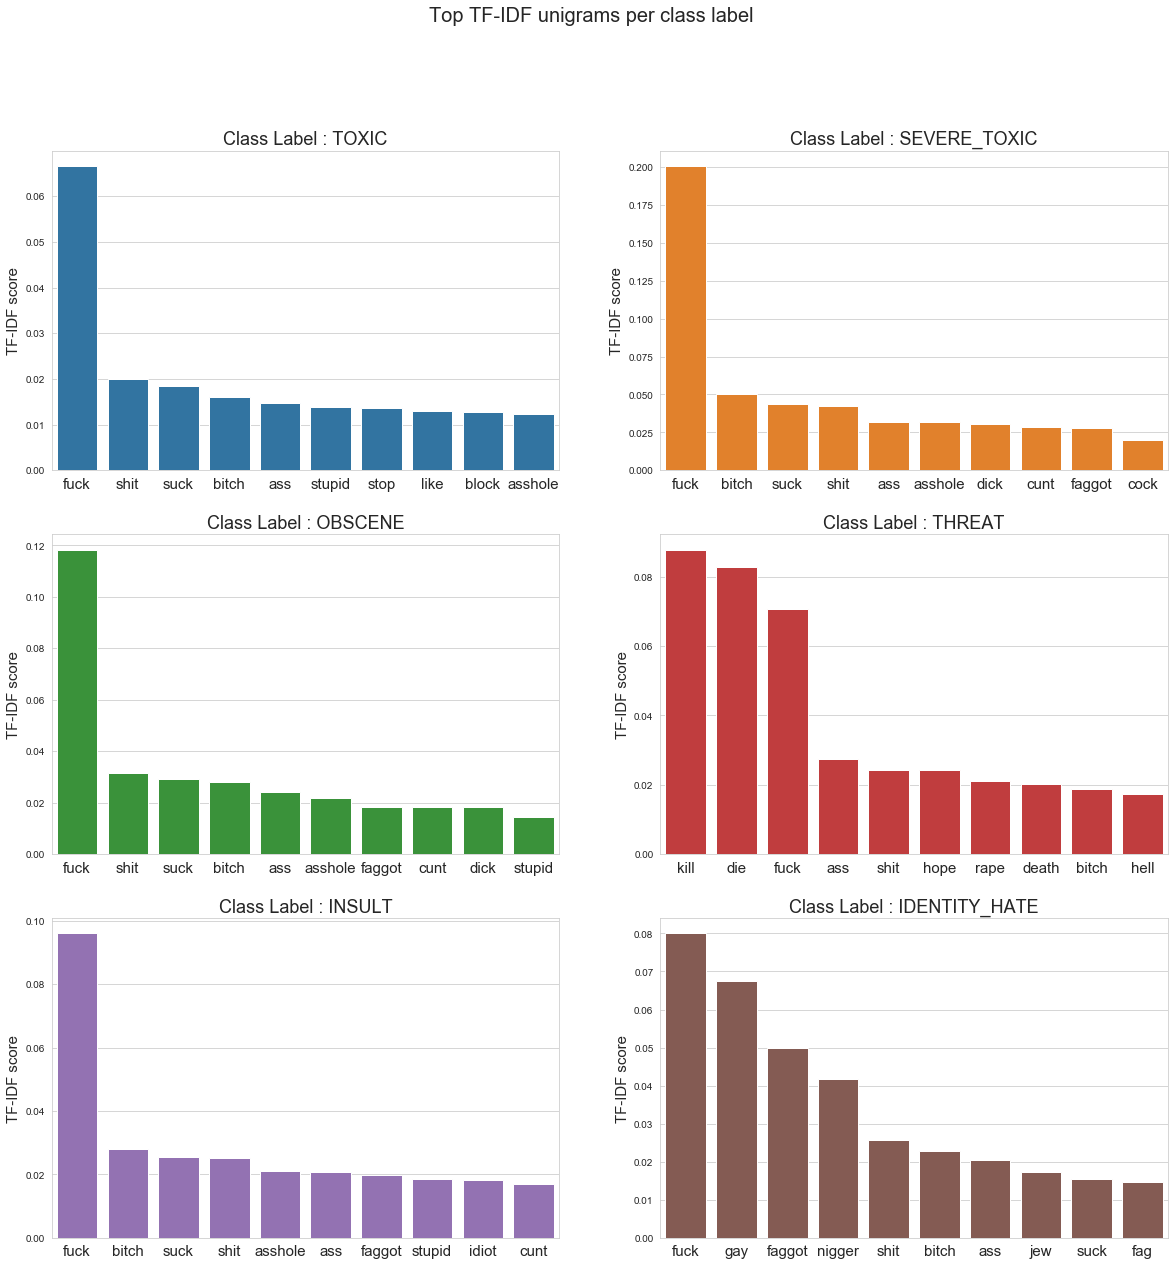

In [14]:
plot_top_ngrams_by_label(top_tfidf_ngrams['unigrams'], ngram_type = 'unigrams')

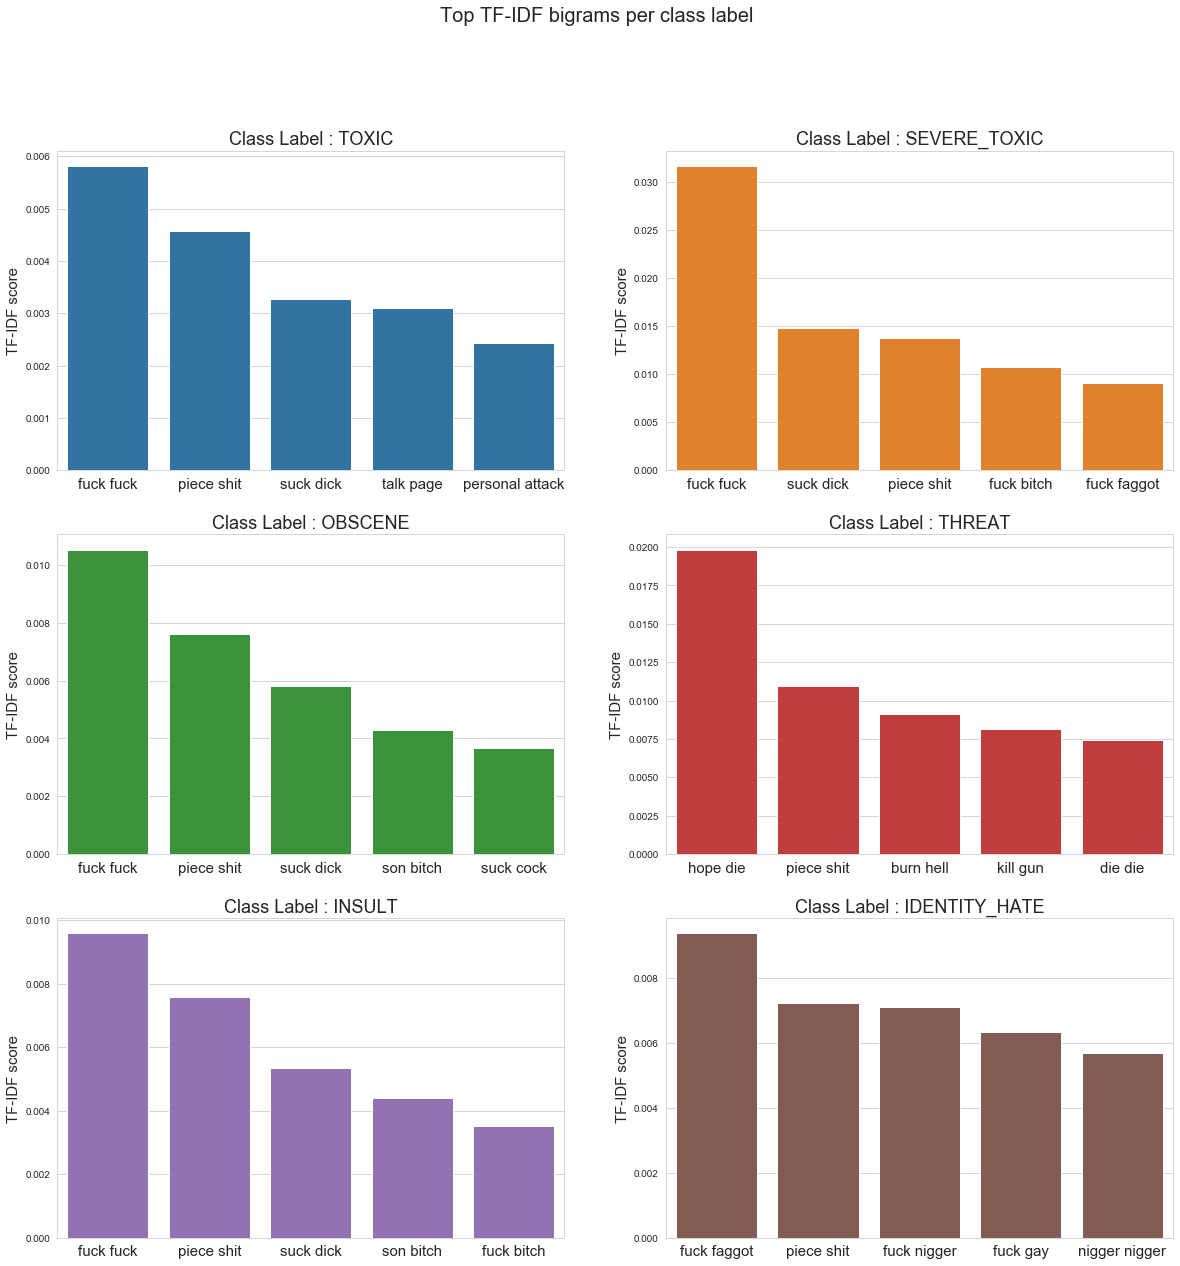

In [15]:
plot_top_ngrams_by_label(top_tfidf_ngrams['bigrams'], top_n=5, ngram_type = 'bigrams')

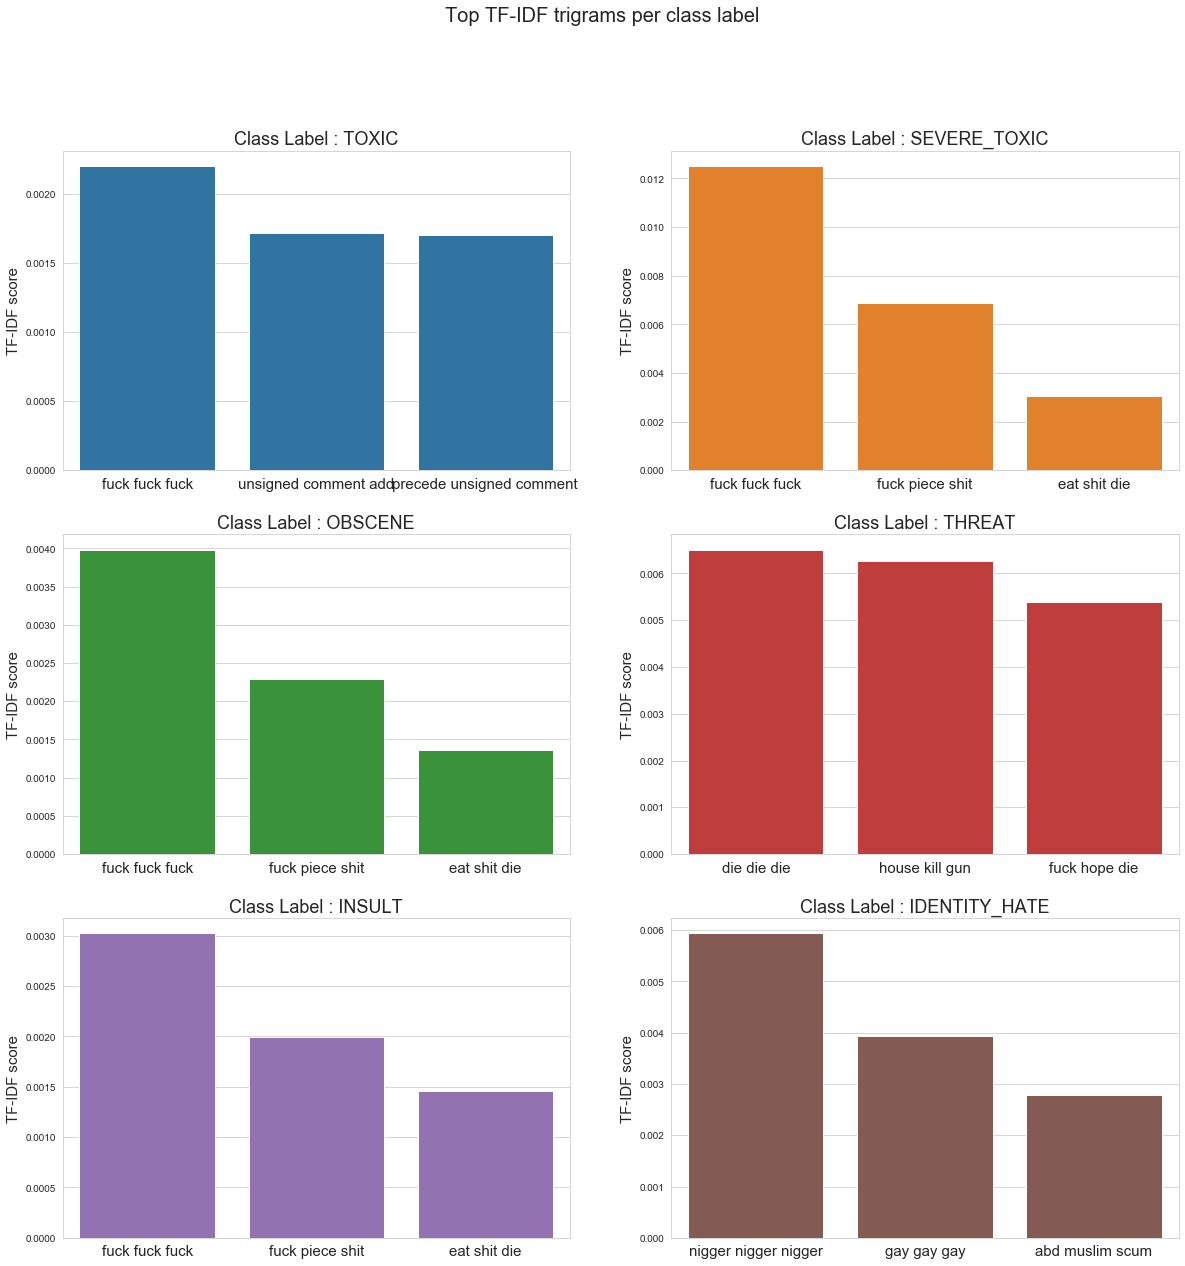

In [16]:
plot_top_ngrams_by_label(top_tfidf_ngrams['trigrams'], top_n=3, ngram_type = 'trigrams')

In [17]:
del tfv, top_tfidf_ngrams, X_train_tfv, features; gc.collect()

52110

In [18]:
tfv = TfidfVectorizer(min_df=5,  
                      max_features=30000, 
                      strip_accents='unicode', 
                      analyzer='word',
                      token_pattern=r'\w{2,}',
                      ngram_range=(1,2), 
                      sublinear_tf=1,
                      stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(df_all['comment'].values)
X_train_tfv =  tfv.transform(df_all.iloc[:len(df_train)]['comment'].values) 
X_test_tfv = tfv.transform(df_all.iloc[len(df_train):]['comment'].values)

In [19]:
y = df_train.loc[:,CLASSES].values

In [20]:
dump_objects(DATA_DIR + 'X_train_tfv', X_train_tfv)
dump_objects(DATA_DIR + 'X_test_tfv', X_test_tfv)

In [21]:
dump_objects(DATA_DIR + 'y', y)